In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on the Manifold of Symmetric Positive Definite Matrices (SPD)

This notebook shows how define and evaluate kernels on the manifold of symmetric positive definite matrices $\mathbb{SPD}(2)$ of size $2 \times 2$.

Handling higher-dimensional manifolds of symmetric positive definite matrices $\mathbb{SPD}(d)$ for $d > 2$ is essentially the same.

**Note:** the points on the hyperbolic space $\mathbb{SPD}(d)$ are represented by matrices (`array`s of the suitable backend) or size $d \times d$.

We use the **numpy** backend here.

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import SymmetricPositiveDefiniteMatrices
from geometric_kernels.kernels import MaternGeometricKernel

import matplotlib as mpl
import matplotlib.pyplot as plt

import geomstats.visualization as visualization

INFO: Using numpy backend


## Defining a Space

First we create a GeometricKernels `space` that corresponds to the 2-dimensional manifold of symmetric positive definite matrices $\mathbb{SPD}(2)$.

In [3]:
spd = SymmetricPositiveDefiniteMatrices(2)

## Defining a Kernel

To initialize `MaternGeometricKernel` you need to provide a `Space` object, in our case this is the `hyperbolic_space` we have just created above.
Additionally, there is a mandatory keyword argument `key` which should be equal to a random generator that is **specific to the backend you are using**.
This is because `MaternGeometricKernel` on non-compact symmetric spaces is a random Monte Carlo approximation. Notably, this implies that kernel can be (slightly) different every time.

There is also an optional parameter `num` which determines the order of approximation of the kernel (*number of levels*).
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on non-compact symmetric spaces (which hyperbolic spaces are instances of) can be found on this [documentation page](https://gpflow.github.io/GeometricKernels/theory/symmetric.html).

First, we define randomness

In [4]:
key = np.random.RandomState(seed=1234)

Now we are ready to create a generic Matérn kernel.

In [5]:
kernel = MaternGeometricKernel(spd, key=key)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [6]:
params = kernel.init_params()
print('params:', params)

params: {'nu': array(inf), 'lengthscale': array(1.)}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [7]:
params["lengthscale"] = np.array([0.5])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `10` random points on the sphere $\mathbb{H}_2$.
Since manifolds of positive definite matrices are noncompact, the sampling cannot be uniform.
Here we resort to the default sampling routine from the [geomstats](https://geomstats.github.io/index.html) package.

In [8]:
xs = spd.random_point(10)

print(xs)

[[[ 1.70596512  0.20192914]
  [ 0.20192914  0.87933942]]

 [[ 0.91316666 -0.60912328]
  [-0.60912328  2.25331529]]

 [[ 1.19833988 -0.18929935]
  [-0.18929935  0.69014529]]

 [[ 0.44183581  0.00363106]
  [ 0.00363106  1.63975199]]

 [[ 0.95311537  0.10585256]
  [ 0.10585256  1.43783946]]

 [[ 1.79461176 -0.15961321]
  [-0.15961321  1.42022269]]

 [[ 0.64016689 -0.01633257]
  [-0.01633257  1.12567867]]

 [[ 2.6196062   1.02192647]
  [ 1.02192647  1.36591502]]

 [[ 0.45042048  0.12290574]
  [ 0.12290574  0.66853643]]

 [[ 1.37314164 -1.14414827]
  [-1.14414827  2.37804931]]]


Now we evaluate the two kernel matrices.

In [9]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

Finally, we visualize these matrices using `imshow`.

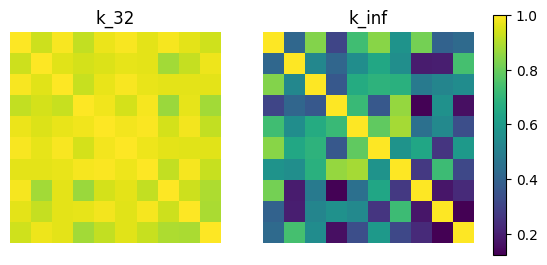

In [10]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

# Citation

If you are using manifolds of symmetric positive definite matrices and GeometricKernels, please consider citing

```
@article{azangulov2023,
    title={Stationary Kernels and Gaussian Processes on Lie Groups and their Homogeneous Spaces II: non-compact symmetric spaces},
    author={Azangulov, Iskander and Smolensky, Andrei and Terenin, Alexander and Borovitskiy, Viacheslav},
    journal={arXiv preprint arXiv:2301.13088},
    year={2023}
}
```